# Only Pz remains for many synaptic inputs

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import LFPy
from lfpykit.models import CurrentDipoleMoment
from brainsignals.plotting_convention import mark_subplots
from elephant.spike_train_generation import inhomogeneous_poisson_process
import brainsignals.neural_simulations as ns
import synaptic_properties as sp
from figure_plots import amp_FT

### Define parameters and set up neuron structure

In [2]:
np.random.seed(1234)
dt = 2**-4
tstop = 400
num_tsteps = int(tstop / dt) + 1
tvec = np.arange(num_tsteps) * dt
freq = 20 # Hz
avrg_rate = 700 # Hz

# Synaptic rateprofiles
syn_rate_0 = sp.syn_rate(tvec, dt, freq, avrg_rate, phase=0)
syn_rate_pi = sp.syn_rate(tvec, dt, freq, avrg_rate, phase=np.pi)

# Store for plotting
cell = ns.return_hay_cell(tstop, dt, make_passive=False)
cell_x, cell_z = cell.x.copy(), cell.z.copy()
del cell

### Simulating baseline neuron

In [3]:
cell = ns.return_hay_cell(tstop, dt, make_passive=False)
synidxs_ex = sp.synapses_locs(cell, -200, 100, 100)
synidxs_in = sp.synapses_locs(cell, -200, 100, 100)
del cell

cell = ns.return_hay_cell(tstop, dt, make_passive=False)

# Simultaneous input
avrg_rate = 1000
synapse_params_ex = sp.synapse_params(0)
synapse_params_in = sp.synapse_params(-90)

# Excitatory
for synidx in synidxs_ex:
    synapse_params_ex["idx"] = synidx
    synapse = LFPy.Synapse(cell, **synapse_params_ex)
    spiketimes_rate = inhomogeneous_poisson_process(sp.syn_rate(tvec, dt, freq, avrg_rate, phase=0) * 1.2)
    synapse.set_spike_times(np.array(spiketimes_rate)*1000)

# Inhibitory
for s_, synidx in enumerate(synidxs_in):
    synapse_params_in["idx"] = synidx
    synapse = LFPy.Synapse(cell, **synapse_params_in)
    spiketimes_rate = inhomogeneous_poisson_process(sp.syn_rate(tvec, dt, freq, avrg_rate, phase=180) * 1.2)
    synapse.set_spike_times(np.array(spiketimes_rate)*1000)

cell.simulate(rec_imem=True, rec_vmem=True)

cdms_1 = CurrentDipoleMoment(cell).get_transformation_matrix() @ cell.imem

del cell
del synapse

Changing temperature 34.00 to 34.00
Changing temperature 34.00 to 34.00


### Simulating alternative neuron

In [4]:
cell = ns.return_hay_cell(tstop, dt, make_passive=False)
synidxs_bot_ex = sp.synapses_locs(cell, -1e9, 300, 50)
synidxs_bot_in = sp.synapses_locs(cell, -1e9, 300, 50)
synidxs_top_ex = sp.synapses_locs(cell, 900, 1200, 50)
synidxs_top_in = sp.synapses_locs(cell, 900, 1200, 50)
del cell

cell = ns.return_hay_cell(tstop, dt, make_passive=False)

# Simultaneous input bot
synapse_params_ex = sp.synapse_params(0)
synapse_params_in = sp.synapse_params(-90)

# Excitatory
for synidx in synidxs_bot_ex:
    synapse_params_ex["idx"] = synidx
    synapse = LFPy.Synapse(cell, **synapse_params_ex)
    spiketimes_rate = inhomogeneous_poisson_process(syn_rate_0 * 1.2)
    synapse.set_spike_times(np.array(spiketimes_rate)*1000)

# Inhibitory
for synidx in synidxs_bot_in:
    synapse_params_in["idx"] = synidx
    synapse = LFPy.Synapse(cell, **synapse_params_in)
    spiketimes_rate = inhomogeneous_poisson_process(syn_rate_pi * 1.2)
    synapse.set_spike_times(np.array(spiketimes_rate)*1000)

# Simultaneous input top
synapse_params_ex = sp.synapse_params(0)
synapse_params_in = sp.synapse_params(-90)

# Excitatory
for synidx in synidxs_top_ex:
    synapse_params_ex["idx"] = synidx
    synapse = LFPy.Synapse(cell, **synapse_params_ex)
    spiketimes_rate = inhomogeneous_poisson_process(syn_rate_pi * 1.2)
    synapse.set_spike_times(np.array(spiketimes_rate)*1000)
    
# Inhibitory
for synidx in synidxs_top_in:
    synapse_params_in["idx"] = synidx
    synapse = LFPy.Synapse(cell, **synapse_params_in)
    spiketimes_rate = inhomogeneous_poisson_process(syn_rate_0 * 1.2)
    synapse.set_spike_times(np.array(spiketimes_rate)*1000)

cell.simulate(rec_imem=True, rec_vmem=True)

cdms_2 = CurrentDipoleMoment(cell).get_transformation_matrix() @ cell.imem

del cell
del synapse

Changing temperature 34.00 to 34.00
Changing temperature 34.00 to 34.00


### Extract CDM amplitudes

In [5]:
cdms_FT_1 = cdms_1[2, tvec>100]
cdms_FT_2 = cdms_2[2, tvec>100]
tvec_FT = tvec[tvec>100]

cdms_freq_1, cdms_amp_1 = amp_FT(tvec_FT, cdms_FT_1, freq)
cdms_freq_2, cdms_amp_2 = amp_FT(tvec_FT, cdms_FT_2, freq)

20.0 112.63356569002858
20.0 198.7856838614849


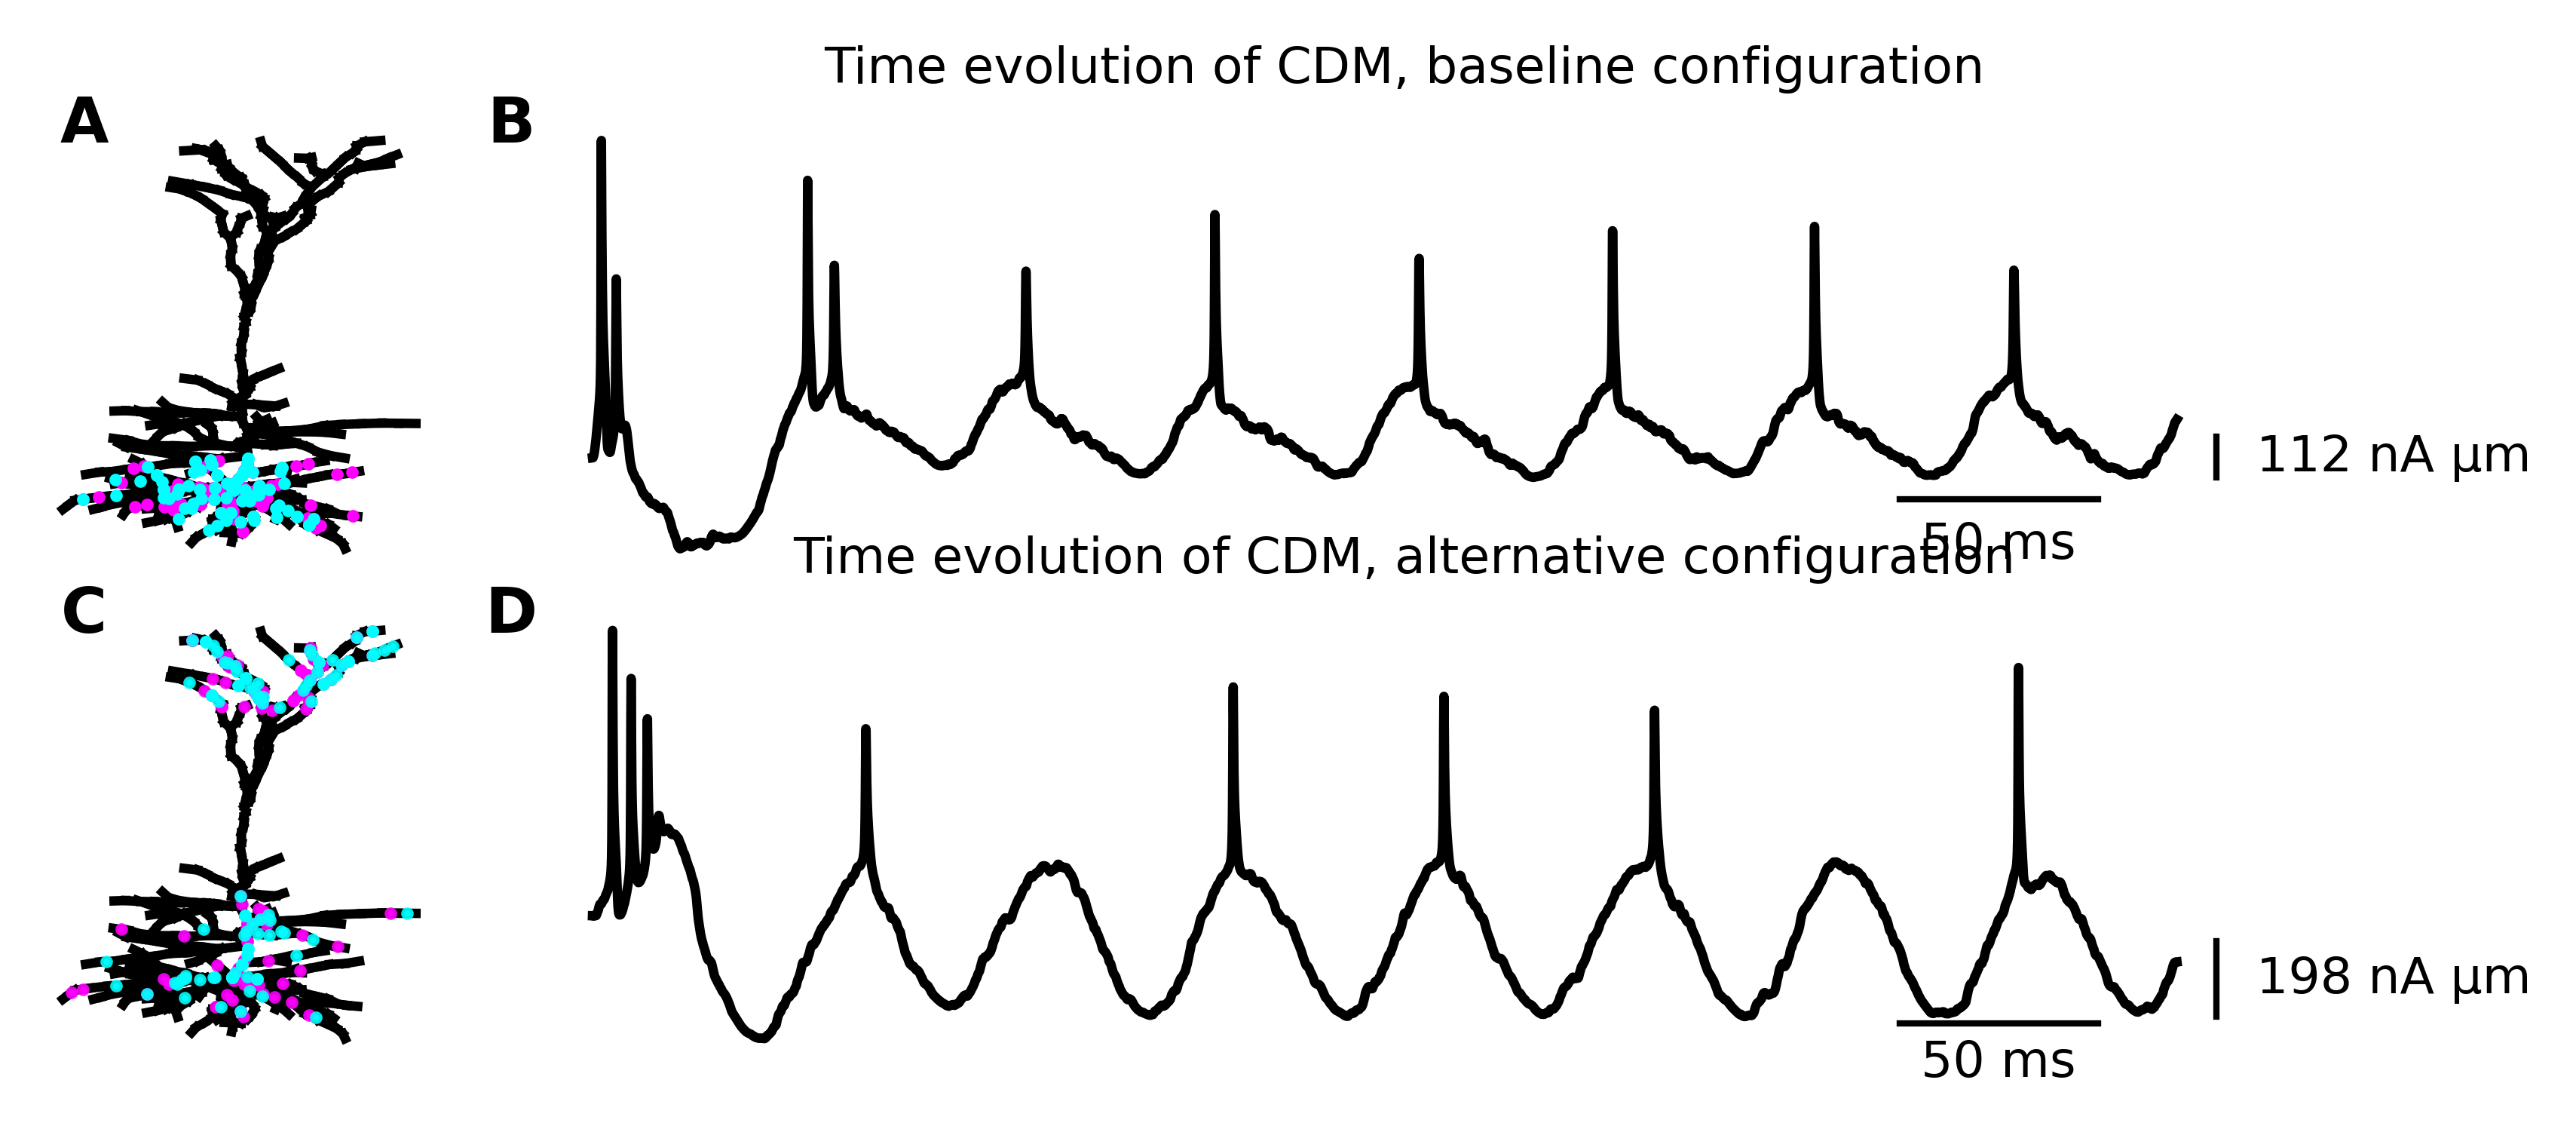

In [6]:
fig, axd = plt.subplot_mosaic([['ax1', 'cdm1', 'cdm1', 'cdm1', 'cdm1'],
                               ['ax1', 'cdm1', 'cdm1', 'cdm1', 'cdm1'],
                               ['ax2', 'cdm2', 'cdm2', 'cdm2', 'cdm2'],
                               ['ax2', 'cdm2', 'cdm2', 'cdm2', 'cdm2']])

plt.rcParams["figure.figsize"] = (5.1, 4.5)

fig.subplots_adjust(bottom=0.05, top=0.88, right=0.88, left=0.05,
                    wspace=0.2, hspace=0.2,)

axd['ax1'].plot(cell_x.T, cell_z.T, c='k')
axd['ax1'].set_axis_off()
axd['ax1'].plot(cell_x[synidxs_ex].mean(axis=1), 
                cell_z[synidxs_ex].mean(axis=1), 
                'o', ms=1, c='magenta')
axd['ax1'].plot(cell_x[synidxs_in].mean(axis=1), 
                cell_z[synidxs_in].mean(axis=1), 
                'o', ms=1, c='cyan')

axd['ax2'].plot(cell_x.T, cell_z.T, c='k')
axd['ax2'].set_axis_off()
axd['ax2'].plot(cell_x[synidxs_top_ex].mean(axis=1), 
                cell_z[synidxs_top_ex].mean(axis=1), 
                'o', ms=1, c='magenta', alpha=0.9)
axd['ax2'].plot(cell_x[synidxs_bot_ex].mean(axis=1), 
                cell_z[synidxs_bot_ex].mean(axis=1), 
                'o', ms=1, c='magenta', alpha=0.9)
axd['ax2'].plot(cell_x[synidxs_top_in].mean(axis=1), 
                cell_z[synidxs_top_in].mean(axis=1), 
                'o', ms=1, c='cyan', alpha=0.9)
axd['ax2'].plot(cell_x[synidxs_bot_in].mean(axis=1), 
                cell_z[synidxs_bot_in].mean(axis=1), 
                'o', ms=1, c='cyan', alpha=0.9)

axd['cdm1'].plot([tvec[-1] + 10, tvec[-1] + 10], 
                 [min(cdms_1[2, tvec>100]), min(cdms_1[2, tvec>100]) + cdms_amp_1], 
                 clip_on=False, c='k', lw=1)
axd['cdm1'].text(tvec[-1] + 20, min(cdms_1[2, tvec>100]) + cdms_amp_1/2, "{:d} nA µm".format(int(cdms_amp_1)),
              ha='left', va="center")
axd['cdm1'].plot([tvec[-1] - 70, tvec[-1] - 20], 
                 [min(cdms_1[2, tvec>100])-60, min(cdms_1[2, tvec>100])-60], 
                 clip_on=False, c='k', lw=1)
axd['cdm1'].text(tvec[-1] - 20 - 25, min(cdms_1[2, tvec>100])-120, "50 ms",
              ha='center', va="top")
axd['cdm1'].set_title('Time evolution of CDM, baseline configuration')
axd['cdm1'].plot(tvec, cdms_1[2, :], c='k')
axd['cdm1'].set_axis_off()

axd['cdm2'].plot([tvec[-1] + 10, tvec[-1] + 10], 
                 [min(cdms_2[2, tvec>100]), min(cdms_2[2, tvec>100]) + cdms_amp_2], 
                 clip_on=False, c='k', lw=1)
axd['cdm2'].text(tvec[-1] + 20, min(cdms_2[2, tvec>100]) + cdms_amp_2/2, "{:d} nA µm".format(int(cdms_amp_2)),
              ha='left', va="center")
axd['cdm2'].plot([tvec[-1] - 70, tvec[-1] - 20], 
                 [min(cdms_1[2, tvec>100])-230, min(cdms_1[2, tvec>100])-230], 
                 clip_on=False, c='k', lw=1)
axd['cdm2'].text(tvec[-1] - 20 - 25, min(cdms_1[2, tvec>100])-270, "50 ms",
              ha='center', va="top")
axd['cdm2'].set_title('Time evolution of CDM, alternative configuration')
axd['cdm2'].plot(tvec, cdms_2[2, :], c='k')
axd['cdm2'].set_axis_off()

mark_subplots(axd['ax1'], "A", xpos=0.1, ypos=.99)
mark_subplots(axd['ax2'], "C", xpos=0.1, ypos=.99)
mark_subplots(axd['cdm1'], "B", xpos=0.0, ypos=.99)
mark_subplots(axd['cdm2'], "D", xpos=0.0, ypos=.99)

plt.savefig('Time_evolution_CDM.pdf')